# Single Dummy Estimates

This tutorial shows the use of a neural network to estimate the number of tricks which will be taken on a given open lead in a given contract (single dummy)

In this tutorial we'll access a bit lower-level APIs.


In [1]:
import sys
sys.path.append('../../src')

import numpy as np
import matplotlib.pyplot as plt

import scoring
import deck52

from nn.models import Models
from bidding import bidding
from bidding.binary import parse_hand_f
from bots import BotBid
from objects import Card
from util import hand_to_str
from sample import Sample
import conf

np.set_printoptions(precision=2, suppress=True, linewidth=200)
np.random.seed(42)


Instructions for updating:
non-resource variables are not supported in the long term


In [2]:
models = Models.from_conf(conf.load('../Conf/UCBC2024.conf'),'..')   # loading neural networks
sampler = Sample.from_conf(conf.load('../Conf/UCBC2024.conf'), False)  # Load sampling strategies


INFO:tensorflow:Restoring parameters from ..\Models/NS1EW99-bidding-3233000
INFO:tensorflow:Restoring parameters from ..\Models/NS1EW99-binfo-3233000
INFO:tensorflow:Restoring parameters from ..\Models/lead_suit-154000
INFO:tensorflow:Restoring parameters from ..\Models/lead_nt-59000
INFO:tensorflow:Restoring parameters from ..\Models/single_dummy-312000
INFO:tensorflow:Restoring parameters from ..\Models/lefty-1000000
INFO:tensorflow:Restoring parameters from ..\Models/dummy-920000
INFO:tensorflow:Restoring parameters from ..\Models/righty-1000000
INFO:tensorflow:Restoring parameters from ..\Models/decl-1000000


In [3]:
# helper functions are defined here. it's ok to scroll over this part

# this is the function which does the prediction
# for each possible number of tricks (from 0 to 13) 
# it returns the probability that that number of tricks will be taken (single dummy)
def single_dummy(model, hands, decl_i, strain_i, lead_card_i):
    # an array, which is the input for the neural network, is prepared
    X_sd = np.zeros((hands.shape[0], 32 + 5 + 4*32))
    X_sd[:,32 + strain_i] = 1
    X_sd[:,(32 + 5 + 0*32):(32 + 5 + 1*32)] = hands[:, (decl_i + 1) % 4]
    X_sd[:,(32 + 5 + 1*32):(32 + 5 + 2*32)] = hands[:, (decl_i + 2) % 4]
    X_sd[:,(32 + 5 + 2*32):(32 + 5 + 3*32)] = hands[:, (decl_i + 3) % 4]
    X_sd[:,(32 + 5 + 3*32):] = hands[:, decl_i]
    X_sd[:, lead_card_i] = 1
    
    return model(X_sd)

# plotting the trick probability distribution
def plot_tricks(tricks_softmax):
    tricks = tricks_softmax[0]
    plt.bar(range(14), tricks)
    plt.title(f'E(tricks) = {tricks @ np.arange(14)}')
    plt.xlabel('# tricks')
    plt.ylabel('probability')

def expected_score(tricks_softmax, contract, vuln):
    tricks = tricks_softmax
    score_by_tricks = np.array([scoring.score(contract, vuln, i) for i in range(14)])
    return tricks @ score_by_tricks

In [4]:
# we take the following hand as an example
# West plays it in 3N on a small heart lead
# how many tricks will declarer take?

hands_str = 'AK98x.Axxx.Q8x.x J.98x.9xx.AT98xx Qxxxx.QJx.AKTx.x Tx.KTx.Jxx.KQJxx'  # N E S W
contract = '2SS'
opening_lead = 'CA'

In [5]:
# this line just converts the string representation of the hands into a binary format
hands = np.vstack([parse_hand_f(32)(s) for s in hands_str.split()]).reshape((-1, 4, 32))

print(hands)
# applying the function which does the prediction
tricks_distr = single_dummy(
    models.sd_model.model, 
    hands, 
    decl_i='NESW'.index(contract[-1]), 
    strain_i='NSHDC'.index(contract[1]), 
    lead_card_i=deck52.card52to32(Card.from_symbol(opening_lead).code())
)

[[[1 1 0 0 0 1 1 1 1 0 0 0 0 0 0 3 0 0 1 0 0 0 1 1 0 0 0 0 0 0 0 1]
  [0 0 0 1 0 0 0 0 0 0 0 0 0 1 1 1 0 0 0 0 0 1 0 2 1 0 0 0 1 1 1 2]
  [0 0 1 0 0 0 0 4 0 0 1 1 0 0 0 1 1 1 0 0 1 0 0 1 0 0 0 0 0 0 0 1]
  [0 0 0 0 1 0 0 1 0 1 0 0 1 0 0 1 0 0 0 1 0 0 0 2 0 1 1 1 0 0 0 2]]]


In [6]:
# the result is an array representing the probability distribution of tricks
# the first element of the array is the probability that declarer will take 0 tricks
# the last element of the array is the probability that declarer will take 13 tricks
tricks_distr

array([[0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.02, 0.05, 0.09, 0.13, 0.22, 0.26, 0.25]], dtype=float32)

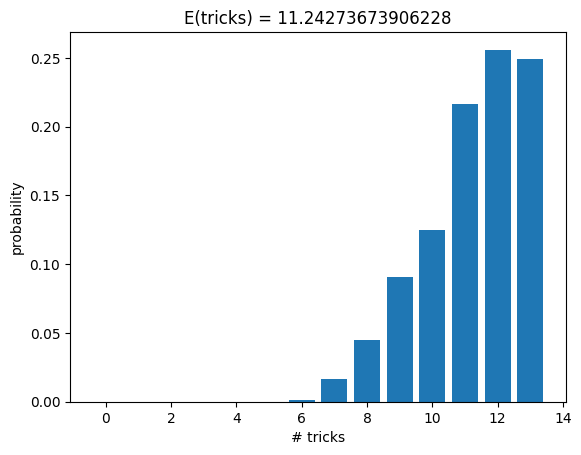

In [7]:
# we can also plot it to see it better
plot_tricks(tricks_distr)

In [8]:
# we can also compute how much declarer is expected to score on this hand (non-vulnerable)
expected_score(tricks_distr, contract='4S', vuln=False)[0]

388.299034156948

In [9]:
# or we can get the probability that the contract will be made (i.e declarer will take 12 or more tricks)
np.sum(tricks_distr[:,12:])

0.5053919